# Downloading Data From Kaggle for Google Colab 

In [ ]:
!mkdir ~/.kaggle 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!mkdir ~/.kaggle 

In [ ]:
!echo '{"username":"","key":""}' > ~/.kaggle/kaggle.json   #Kaggle API credentials file (my key is redacted), obtained form Kaggle account

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json        #Set permissions for credential file

In [ ]:
!pip install kaggle        #Confirm Kaggle API is installed, is by default in Colab

In [ ]:
!kaggle competitions download -c painter-by-numbers -f train.zip        #Directly download training dataset from Kaggle, uploading from local computer is not feasible

100% 36.0G/36.0G [11:16<00:00, 84.0MB/s]
100% 36.0G/36.0G [11:16<00:00, 57.2MB/s]


In [ ]:
!unzip -o -q train.zip                                     #Decompress training images

In [ ]:
!rm -r train.zip                    #Free up space 

In [ ]:
!kaggle competitions download -c painter-by-numbers -f test.zip     #Download test images dataset

100% 11.1G/11.1G [03:14<00:00, 47.9MB/s]
100% 11.1G/11.1G [03:14<00:00, 61.1MB/s]


In [ ]:
!unzip -o -q test.zip 

In [ ]:
!rm -r test.zip

In [ ]:
!du -h train/                          #Check proper decompression and presence of full training set (known from local computer)

37G	train/


In [ ]:
!kaggle competitions download -c painter-by-numbers -f replacements_for_corrupted_files.zip      #Corrupt file replacements

 97% 17.0M/17.5M [00:00<00:00, 22.4MB/s]
100% 17.5M/17.5M [00:00<00:00, 32.5MB/s]


In [ ]:
!unzip -o -q replacements_for_corrupted_files.zip 

In [ ]:
!kaggle competitions download -c painter-by-numbers -f all_data_info.csv             #CSV file containing metadata on each image 

  0% 0.00/3.80M [00:00<?, ?B/s]
100% 3.80M/3.80M [00:00<00:00, 62.3MB/s]


In [ ]:
!unzip -q all_data_info.csv.zip

# Start of Modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Certain Parameter values for selecting training subsets
num_classes=20     #Number of classes to target
SampleSize=750    #Number of samples per class to include in training (check below 'styles' series to see number of examples per class in raw data)

In [ ]:
df=pd.read_csv("all_data_info.csv")

### Filtering 

In [ ]:
df=df.drop(df[df['style'].isna()].index)          #Drop null values for in style column
df['pixels']=df['pixelsx']*df['pixelsy']
df=df.drop(df[df['pixels']>89478485].index)      #Drop images above certain pixel size which seems to cause processing bomb error
df=df.drop(df[df['size_bytes']>5.4e7].index)      #Drop images under certain size to again reduce processing error for too large size
dftest=df[df['in_train']==False]                    #Store training set images in dataframe
df=df[df['in_train']==True]                        #Store testing set images in dataframe

In [ ]:
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,pixels
5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg,76584000.0
6,Barnett Newman,NaN,abstract,7345.0,8640.0,6383948.0,wikiart,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II",train_only,True,62252.jpg,63460800.0
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg,49638094.0
10,Hiroshige,1844,bird-and-flower painting,5492.0,8283.0,10736273.0,wikiart,Ukiyo-e,Camellia and Bush Warbler,train_and_test,True,53180.jpg,45490236.0
11,Wolfgang Paalen,1937.0,landscape,5331.0,8351.0,1407667.0,wikiart,Surrealism,Forbidden Land,train_only,True,70944.jpg,44519181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103241,Tihamer Gyarmathy,1957.0,abstract,316.0,475.0,89274.0,wikiart,Abstract Art,Structures and Signs,train_and_test,True,36690.jpg,150100.0
103244,Anne Ryan,1954.0,NaN,534.0,281.0,54145.0,wikiart,Abstract Expressionism,Number 547,train_only,True,23862.jpg,150054.0
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg,150040.0
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg,150024.0


In [ ]:
styles=df['style'].value_counts()           #Series holding number of images in each style class
styles.head(num_classes)                    #Look at only top (20) classes and their counts

Impressionism                   8220
Realism                         8112
Romanticism                     7041
Expressionism                   5325
Post-Impressionism              4527
Art Nouveau (Modern)            3779
Baroque                         3254
Surrealism                      3133
Symbolism                       2626
Rococo                          2101
Northern Renaissance            1824
Naïve Art (Primitivism)         1776
Neoclassicism                   1622
Abstract Expressionism          1546
Cubism                          1316
Ukiyo-e                         1137
Early Renaissance               1052
High Renaissance                1050
Mannerism (Late Renaissance)    1025
Art Informel                     987
Name: style, dtype: int64

In [ ]:
stylestest=dftest['style'].isin(styles.head(num_classes).index)  #Create filter for rows with style in top 20
dftest=dftest[stylestest]                                       #Filter test dataframe to only hold images from selected classes

In [ ]:
styles=df['style'].isin(styles.head(num_classes).index)  #Create filter for rows with style in top 20
samples=df[styles]                                       #Filter test dataframe to only hold images from selected classes
samples=samples.groupby('style').apply(lambda x: x.loc[np.random.choice(x.index, SampleSize, False),:])    #group images of same style, randomly selecting SampleSize number of them for each class
samples

artist  ...      pixels
style                                                   ...            
Abstract Expressionism 29649              Horia Bernea  ...    998000.0
                       91239               Sam Francis  ...    238830.0
                       84555           Jackson Pollock  ...    285430.0
                       704                   Eva Hesse  ...  11182320.0
                       88051  Clarence Holbrook Carter  ...    260400.0
...                                                ...  ...         ...
Ukiyo-e                3444         Katsushika Hokusai  ...   5645430.0
                       48701               Ogata Gekko  ...    720896.0
                       10035              Keisai Eisen  ...   2918000.0
                       73968        Katsushika Hokusai  ...    402432.0
                       62811             Toyota Hokkei  ...    517632.0

[15000 rows x 13 columns]

In [ ]:
samples.reset_index(drop=True, inplace=True)         #Remove double index groupby category
from sklearn.utils import shuffle                     
samples=shuffle(samples)                             #Shuffle various style images (currently segregrated by style) for training

### Model fitting

In [ ]:
from tensorflow.keras.models import Sequential         #Load various layer types for CNN
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator   #Image Generator for loading images in batches
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                    #Prevent reading error for images which don't have correct size
from PIL import Image
Image.MAX_IMAGE_PIXELS = None                              #Prevent decompression bomb error for large images

Define image generators

In [ ]:
trainpath = 'train'              #Training images folder

train_limit=int(len(samples)*0.75)         #Select first 75% of filtered and shuffled rows of training dataframe as training set, 25% will be for validation  

valid_gen=ImageDataGenerator(rescale=1./255.)   #rescaling images for validation set

train_gen=ImageDataGenerator(rescale=1./255.,rotation_range = 30,        #rescaling and augmentation of training images
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

height=224             # dimensions to reseize image to, required for certain models, small but preserving reasonable amount of information and commonly used in literature
width=224


train_generator=train_gen.flow_from_dataframe(
dataframe=samples[:train_limit],
directory=trainpath,
x_col="new_filename",           #image file names read in from database column and image fetched from appropriate directory
y_col="style",                 #target variable
#subset="training",
color_mode='rgb',
batch_size=40,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(height,width))

validation_generator=valid_gen.flow_from_dataframe(     #similar for validation image dataset generator
dataframe=samples[train_limit:],
directory=trainpath,
x_col="new_filename",
y_col="style",
#subset="validation",
color_mode='rgb',
batch_size=40,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(height,width))

Found 7500 validated image filenames belonging to 20 classes.
Found 2500 validated image filenames belonging to 20 classes.


Xception pre-trained model fitting

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception 

model3 = Xception (weights='imagenet',            #keep weights optimized for imagenet dataset
                   include_top=False,              #remove last layer
                   input_shape=(height,width,3))

for layer in model3.layers:                              #Freeze weights
    layer.trainable = False

# Add additional layers at end
x = model3.output 
x = Flatten()(x) 
x = Dense(300, activation='relu')(x)      #Add activation layers to bring down nodes per layer in stepwise fashion
x = Dense(100, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)      #softmax activation to ensure multiple classes probabilities add upto 1

model3 = Model(inputs=model3.input, 
              outputs=output)

model3.compile(optimizer='Adam',                          #Use ADAM optimizer
              loss='categorical_crossentropy',                #loss function is categorical crossentropy
              metrics=['accuracy'])


model3.fit(train_generator,                              #test if model works
          epochs=1,
          validation_data=validation_generator)

188/188 [==============================] - 427s 2s/step - loss: 6.0727 - accuracy: 0.1083 - val_loss: 2.7421 - val_accuracy: 0.1524


In [ ]:
model3.fit(train_generator,                   #Continue fitting for a few epochs to see performance
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/5
188/188 [==============================] - 396s 2s/step - loss: 2.6755 - accuracy: 0.1780 - val_loss: 2.6414 - val_accuracy: 0.1716
Epoch 2/5
188/188 [==============================] - 391s 2s/step - loss: 2.4938 - accuracy: 0.2207 - val_loss: 2.4662 - val_accuracy: 0.2412
Epoch 3/5
188/188 [==============================] - 389s 2s/step - loss: 2.3082 - accuracy: 0.2653 - val_loss: 2.3493 - val_accuracy: 0.2644
Epoch 4/5
188/188 [==============================] - 389s 2s/step - loss: 2.1976 - accuracy: 0.2927 - val_loss: 2.3357 - val_accuracy: 0.2620
Epoch 5/5
188/188 [==============================] - 396s 2s/step - loss: 2.1056 - accuracy: 0.3177 - val_loss: 2.2892 - val_accuracy: 0.2928


In [ ]:
model3.fit(train_generator,                     #Further continue fitting
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
188/188 [==============================] - 428s 2s/step - loss: 1.9965 - accuracy: 0.3461 - val_loss: 2.2141 - val_accuracy: 0.2940
Epoch 2/6
188/188 [==============================] - 425s 2s/step - loss: 1.9566 - accuracy: 0.3581 - val_loss: 2.2224 - val_accuracy: 0.3068
Epoch 3/6
188/188 [==============================] - 423s 2s/step - loss: 1.8956 - accuracy: 0.3789 - val_loss: 2.3099 - val_accuracy: 0.3012
Epoch 00003: early stopping


Model stops due to callback as validation loss stops decreasing over two epochs. The model seems to stall at around 30% accuracy on validation set. Next attempt unfreezing later layers to improve accuracy. 

In [ ]:
model3.summary()  #output was removed due to long lengthm making working with notebook inconveniant (see exaple in Artist Classification Notebook), it displayed all layers allowing identification of those to be frozen

Unfreezing roughly last 20% of model:

In [ ]:
len(model3.layers)*0.20

27.200000000000003

So, unfreeze last 30 layers (rounding to include blocks, unfreezing upto block12

In [ ]:
from tensorflow.keras import layers

for layer in xmodel.layers:
    layer.trainable = False

for layer in xmodel.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):          #If batch normalization layer, ignore unfreezing as they can destroy values learnt so far from other layers and are not considered retrainable
            layer.trainable = True
xmodel.fit(train_generator,
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
188/188 [==============================] - 389s 2s/step - loss: 2.5620 - accuracy: 0.1953 - val_loss: 3.2112 - val_accuracy: 0.2320
Epoch 2/6
188/188 [==============================] - 380s 2s/step - loss: 2.1552 - accuracy: 0.2907 - val_loss: 2.7799 - val_accuracy: 0.2112
Epoch 3/6
188/188 [==============================] - 379s 2s/step - loss: 2.0049 - accuracy: 0.3332 - val_loss: 2.0851 - val_accuracy: 0.3156
Epoch 4/6
188/188 [==============================] - 376s 2s/step - loss: 1.8593 - accuracy: 0.3784 - val_loss: 2.3528 - val_accuracy: 0.3184
Epoch 5/6
188/188 [==============================] - 379s 2s/step - loss: 1.7584 - accuracy: 0.4117 - val_loss: 2.8499 - val_accuracy: 0.2572
Epoch 00005: early stopping


As can be seen, unfreezing did not seem to help, quickly reaching early stop with swings in validation loss. While validation accuracy did go up by over a percent, it also dropped eventually and overall does not seem significant.

Next, trying ResNet50V2 again (see misc. notebook for initial attempts), but with different final layers (no flatten and dense ReLu activation layers, instead using pooling to reduce nodes). 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D

model4 = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,3))

for layer in model4.layers:
    layer.trainable = False



    # Add our own layers to the end of the network
x = model4.output 
x=AveragePooling2D()(x)
x=GlobalAveragePooling2D()(x)
#x = Flatten()(x) 
##x = Dense(1000, activation='relu')(x)
#x = Dense(100, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model4 = Model(inputs=model4.input, 
              outputs=output)

optimizer = Adam()

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

model4.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model4.fit(train_generator,
          epochs=3,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/3
188/188 [==============================] - 109s 561ms/step - loss: 2.8792 - accuracy: 0.1653 - val_loss: 2.2530 - val_accuracy: 0.3076
Epoch 2/3
188/188 [==============================] - 104s 552ms/step - loss: 2.0454 - accuracy: 0.3634 - val_loss: 2.0992 - val_accuracy: 0.3436
Epoch 3/3
188/188 [==============================] - 106s 563ms/step - loss: 1.8378 - accuracy: 0.4229 - val_loss: 2.1032 - val_accuracy: 0.3556


There is an immediate improvement compared to Xception and earlier ResNet trials, so continueing fitting:

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           mode='min', 
                           verbose=1)
model4.fit(train_generator,
          epochs=5,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/5
188/188 [==============================] - 106s 563ms/step - loss: 1.7540 - accuracy: 0.4476 - val_loss: 2.0867 - val_accuracy: 0.3708
Epoch 2/5
188/188 [==============================] - 106s 566ms/step - loss: 1.6709 - accuracy: 0.4640 - val_loss: 2.0691 - val_accuracy: 0.3772
Epoch 3/5
188/188 [==============================] - 106s 563ms/step - loss: 1.6152 - accuracy: 0.4843 - val_loss: 2.0760 - val_accuracy: 0.3724
Epoch 4/5
188/188 [==============================] - 106s 563ms/step - loss: 1.5448 - accuracy: 0.5015 - val_loss: 2.0460 - val_accuracy: 0.3828
Epoch 5/5
188/188 [==============================] - 106s 563ms/step - loss: 1.5191 - accuracy: 0.5144 - val_loss: 2.0551 - val_accuracy: 0.3876


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           mode='min', 
                           verbose=1)
model4.fit(train_generator,
          epochs=5,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/5
188/188 [==============================] - 107s 568ms/step - loss: 1.4663 - accuracy: 0.5315 - val_loss: 2.0406 - val_accuracy: 0.3904
Epoch 2/5
188/188 [==============================] - 107s 570ms/step - loss: 1.4563 - accuracy: 0.5300 - val_loss: 2.0619 - val_accuracy: 0.3840
Epoch 3/5
188/188 [==============================] - 107s 567ms/step - loss: 1.4163 - accuracy: 0.5441 - val_loss: 2.1096 - val_accuracy: 0.3752
Epoch 4/5
188/188 [==============================] - 107s 569ms/step - loss: 1.3855 - accuracy: 0.5497 - val_loss: 2.0947 - val_accuracy: 0.3920
Epoch 00004: early stopping


Model tops out at about 39% validation accuracy, highest obtained so far. Saving for use after colab sessions ends:

In [ ]:
!mkdir Res_Best
model4.save('Res_Best')

INFO:tensorflow:Assets written to: Res_Best/assets


In [ ]:
cp -r Res_Best/ drive/MyDrive/

Now trying unfreezing last few layers of this model, again making sure to unfreeze blocks together. Number of layers unfrozen is different due to differenct architecture of ResNet compared to Xception

In [ ]:
#Unfreeze 15 last layers (conv5_block3) on Res_Best
from tensorflow.keras import layers

for layer in model4.layers:
    layer.trainable = False

for layer in model4.layers[-15:]:             
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
model4.fit(train_generator,
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
188/188 [==============================] - 107s 567ms/step - loss: 1.3096 - accuracy: 0.5753 - val_loss: 2.1211 - val_accuracy: 0.3912
Epoch 2/6
188/188 [==============================] - 106s 565ms/step - loss: 1.2908 - accuracy: 0.5784 - val_loss: 2.1897 - val_accuracy: 0.3864
Epoch 3/6
188/188 [==============================] - 106s 565ms/step - loss: 1.2717 - accuracy: 0.5879 - val_loss: 2.1431 - val_accuracy: 0.4012
Epoch 4/6
188/188 [==============================] - 104s 556ms/step - loss: 1.2623 - accuracy: 0.5869 - val_loss: 2.1977 - val_accuracy: 0.3896
Epoch 00004: early stopping


In [ ]:
model4.fit(train_generator,
          epochs=10,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/10
188/188 [==============================] - 104s 555ms/step - loss: 1.2542 - accuracy: 0.5936 - val_loss: 2.1558 - val_accuracy: 0.3952
Epoch 2/10
188/188 [==============================] - 104s 554ms/step - loss: 1.2443 - accuracy: 0.5929 - val_loss: 2.1561 - val_accuracy: 0.4008
Epoch 3/10
188/188 [==============================] - 104s 554ms/step - loss: 1.2324 - accuracy: 0.5981 - val_loss: 2.1987 - val_accuracy: 0.3936
Epoch 4/10
188/188 [==============================] - 105s 556ms/step - loss: 1.2076 - accuracy: 0.6076 - val_loss: 2.1806 - val_accuracy: 0.3924
Epoch 00004: early stopping


Slight improvement to accuracy, tried unfreezing 26 layers next (agian similar accuracy numbers) and finally 38 layers:

In [ ]:
for layer in model4.layers[-38:]:             
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
model4.fit(train_generator,
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
188/188 [==============================] - 104s 554ms/step - loss: 1.1795 - accuracy: 0.6207 - val_loss: 2.2314 - val_accuracy: 0.3964
Epoch 2/6
188/188 [==============================] - 103s 549ms/step - loss: 1.1722 - accuracy: 0.6072 - val_loss: 2.2762 - val_accuracy: 0.3936
Epoch 3/6
188/188 [==============================] - 104s 551ms/step - loss: 1.1626 - accuracy: 0.6181 - val_loss: 2.2654 - val_accuracy: 0.4004
Epoch 4/6
188/188 [==============================] - 104s 551ms/step - loss: 1.1617 - accuracy: 0.6136 - val_loss: 2.3199 - val_accuracy: 0.3680
Epoch 00004: early stopping


As can be see, validation loss has started inceasing and unfreezing seems to offer no benefit

In [ ]:
!cp -r drive/MyDrive/Res_Best/ .

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('./Res_Best')

In [ ]:
testpath = 'test'

test_gen=ImageDataGenerator(rescale=1./255.)

height=224
width=224

test_generator=test_gen.flow_from_dataframe(
dataframe=dftest[:8000],
directory=testpath,
x_col="new_filename",
y_col="style",
#subset="training",
color_mode='rgb',
batch_size=60,
seed=42,
#shuffle=True,
class_mode="categorical",
target_size=(height,width))



Found 8000 validated image filenames belonging to 20 classes.


In [ ]:
model4.evaluate(test_generator)

### Experimenting with Cyclical Learning Rate

Code obtained from https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras, adapted to used Xception fit model from above

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *

class CyclicLR(Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# CLR parameters

batch_size = 40
epochs = 10
max_lr = 0.0005
base_lr = max_lr/10
max_m = 0.98
base_m = 0.85

cyclical_momentum = True
#augment = True
cycles = 2.35

iterations = round(7500/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)


model3.compile(loss='binary_crossentropy', optimizer=SGD(0.0000001), metrics=['accuracy'])

clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)
    
callbacks = [clr,
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True)]

history = model3.fit(train_generator,
                              validation_data=validation_generator,
                              epochs = epochs,
                              steps_per_epoch = (7500) // batch_size + 1,
                              validation_steps = (2500) // batch_size + 1,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/10
188/188 [==============================] - 134s 692ms/step - loss: 1.1130 - accuracy: 0.4041 - val_loss: 0.7964 - val_accuracy: 0.2780

Epoch 00001: val_loss improved from inf to 0.79636, saving model to best_model.h5
Epoch 2/10
188/188 [==============================] - 112s 594ms/step - loss: 0.7263 - accuracy: 0.3480 - val_loss: 0.5545 - val_accuracy: 0.2280

Epoch 00002: val_loss improved from 0.79636 to 0.55450, saving model to best_model.h5
Epoch 3/10
188/188 [==============================] - 112s 594ms/step - loss: 0.4842 - accuracy: 0.2552 - val_loss: 0.3232 - val_accuracy: 0.1848

Epoch 00003: val_loss improved from 0.55450 to 0.32320, saving model to best_model.h5
Epoch 4/10
188/188 [==============================] - 110s 587ms/step - loss: 0.2725 - accuracy: 0.2118 - val_loss: 0.2253 - val_accuracy: 0.2072

Epoch 00004: val_loss improved from 0.32320 to 0.22526, saving model to best_model.h5
Epoch 5/10
188/188 [==============================] - 111s 588ms/step - 

##### As can be seen, validation loss was drastically reduced but also at the cost of accuracy down form about 30%. Plotting some of the changing qunatities: 

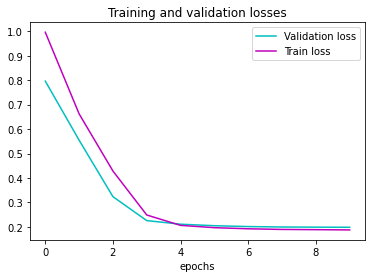

In [ ]:
# Plot losses
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(range(len(val_loss)),val_loss,'c',label='Validation loss')
plt.plot(range(len(loss)),loss,'m',label='Train loss')

plt.title('Training and validation losses')
plt.legend()
plt.xlabel('epochs')
plt.show()

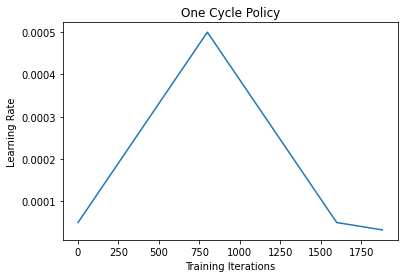

In [ ]:
# Plot Learning Rate
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

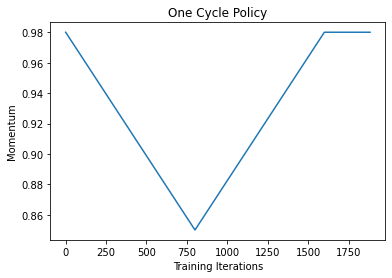

In [ ]:
# Plot momentum
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

Try again with higher max learning rate (0.001, which is the default in Keras, up from the 0.0005 used above):

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# CLR parameters

batch_size = 40
epochs = 10
max_lr = 0.001
base_lr = max_lr/10
max_m = 0.98
base_m = 0.85

cyclical_momentum = True
#augment = True
cycles = 2.35

iterations = round(7500/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)


model3.compile(loss='binary_crossentropy', optimizer=SGD(0.0000001), metrics=['accuracy'])

clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)
    
callbacks = [clr,
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True)]

history = model3.fit(train_generator,
                              validation_data=validation_generator,
                              epochs = epochs,
                              steps_per_epoch = (7500) // batch_size + 1,
                              validation_steps = (2500) // batch_size + 1,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/10
188/188 [==============================] - 114s 590ms/step - loss: 0.1869 - accuracy: 0.2834 - val_loss: 0.1959 - val_accuracy: 0.2448

Epoch 00001: val_loss improved from inf to 0.19594, saving model to best_model.h5
Epoch 2/10
188/188 [==============================] - 109s 580ms/step - loss: 0.1860 - accuracy: 0.2984 - val_loss: 0.1924 - val_accuracy: 0.2500

Epoch 00002: val_loss improved from 0.19594 to 0.19235, saving model to best_model.h5
Epoch 3/10
188/188 [==============================] - 109s 582ms/step - loss: 0.1802 - accuracy: 0.3031 - val_loss: 0.1882 - val_accuracy: 0.2524

Epoch 00003: val_loss improved from 0.19235 to 0.18816, saving model to best_model.h5
Epoch 4/10
188/188 [==============================] - 109s 582ms/step - loss: 0.1779 - accuracy: 0.3147 - val_loss: 0.1842 - val_accuracy: 0.2560

Epoch 00004: val_loss improved from 0.18816 to 0.18420, saving model to best_model.h5
Epoch 5/10
188/188 [==============================] - 109s 582ms/step - 

##### Seems an improvement of about 2-3% in accuracy while still keeping loss fairly low. Next, try cyclical after unfreezing layers:

In [ ]:
from tensorflow.keras import layers

for layer in model3.layers:
    layer.trainable = False

for layer in model3.layers[-40:]:             #Unfreezing upto all block11 layers
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
model3.fit(train_generator,
          epochs=6,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/6
188/188 [==============================] - 106s 566ms/step - loss: 0.1670 - accuracy: 0.3264 - val_loss: 0.1772 - val_accuracy: 0.2700
Epoch 2/6
188/188 [==============================] - 106s 565ms/step - loss: 0.1674 - accuracy: 0.3189 - val_loss: 0.1771 - val_accuracy: 0.2692
Epoch 3/6
188/188 [==============================] - 106s 561ms/step - loss: 0.1673 - accuracy: 0.3172 - val_loss: 0.1769 - val_accuracy: 0.2696
Epoch 4/6
188/188 [==============================] - 106s 561ms/step - loss: 0.1673 - accuracy: 0.3272 - val_loss: 0.1768 - val_accuracy: 0.2700
Epoch 5/6
188/188 [==============================] - 105s 558ms/step - loss: 0.1668 - accuracy: 0.3276 - val_loss: 0.1767 - val_accuracy: 0.2708
Epoch 6/6
188/188 [==============================] - 105s 557ms/step - loss: 0.1668 - accuracy: 0.3185 - val_loss: 0.1766 - val_accuracy: 0.2716


As with earlier fitting, unfreezing seems to have almost no impact. 

In [ ]:
!mkdir Xcep_lowvalloss
model3.save('Xcep_lowvalloss')

INFO:tensorflow:Assets written to: Xcep_lowvalloss/assets
